In [1]:
import json
import torch
from textwrap import shorten
from sentence_transformers import SentenceTransformer
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree, to_undirected
from pyvis.network import Network
import matplotlib.colors as mcolors
import matplotlib.cm as cm

DATASET_PATH = "../data/wiki_graph_restored_knn.json"

### Let's load the dataset after all the filtering steps

In [2]:
dataset_json = json.loads(open(DATASET_PATH, "r").read())

In [3]:
nodes_dict = dataset_json['nodes']
edges_list = dataset_json['edges']

titles = list(nodes_dict.keys())
title_to_idx = {title: i for i, title in enumerate(titles)}

categories = set(d['category'] for d in nodes_dict.values())
cat_to_idx = {cat: i for i, cat in enumerate(categories)}

print(f"Nodes: {len(titles)}, Classes: {len(categories)}")

Nodes: 6093, Classes: 8


In [4]:
cat_to_idx

{'Networking & Protocols': 0,
 'Mathematics & Formal Methods': 1,
 'Programming & Software': 2,
 'Other': 3,
 'Data Management & Databases': 4,
 'Artificial Intelligence & Machine Learning': 5,
 'Systems & Hardware': 6,
 'Computer Security': 7}

### Prepare `edge_index` for PyG library

In [32]:
y = torch.tensor([cat_to_idx[nodes_dict[t]['category']] for t in titles], dtype=torch.long)

# [2, num_edges]
edge_indices = []
self_loops_count = 0

for src, dst in edges_list:
    if src in title_to_idx and dst in title_to_idx and src != dst:
        edge_indices.append([title_to_idx[src], title_to_idx[dst]])
    
    elif src == dst:
        self_loops_count += 1

print(f"Filtered out {self_loops_count} self-loops.")


edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
edge_index = to_undirected(edge_index)

Filtered out 37 self-loops.


In [33]:
edge_index.size()

torch.Size([2, 56470])

### Prepare node features

In [62]:
model_name: str = "jordyvl/scibert_scivocab_uncased_sentence_transformer"
device: str = "mps" if torch.backends.mps.is_available() else "cpu"

print(f"[INFO] Loading embedding model: {model_name} on {device}")

model = SentenceTransformer(model_name, device=device)

query_prompts = [shorten(nodes_dict[t].get("text", ""), width=750) for t in titles]

print(f"[INFO] Generating embeddings for {len(query_prompts)} nodes...")

query_embeddings = model.encode(
    query_prompts,
    batch_size=8,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

print(f"[INFO] Generated embeddings shape: {query_embeddings.shape}")

x = torch.tensor(query_embeddings, dtype=torch.float)

[INFO] Loading embedding model: jordyvl/scibert_scivocab_uncased_sentence_transformer on mps


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

[INFO] Generating embeddings for 6093 nodes...


Batches:   0%|          | 0/762 [00:00<?, ?it/s]

[INFO] Generated embeddings shape: (6093, 768)


### Wrap up the dataset with Data class from PyG

In [64]:
data = Data(x=x, edge_index=edge_index, y=y)

In [66]:
data

Data(x=[6093, 768], edge_index=[2, 56470], y=[6093])

In [65]:
# Save dataset for future use
torch.save(data, "../data/wiki_it_graph_scibert_feats.pt")

### Now let's explore the dataset we have

Graph Statistics:
Number of nodes: 6093
Number of edges (undirected): 28235
PyG internal edges (total message paths): 56470
Average node degree: 9.27
Min degree: 3.0
Max degree: 93.0
Median degree: 9.0
Number of classes: 8
Has isolated nodes: False
Has self-loops: False
Is undirected: True


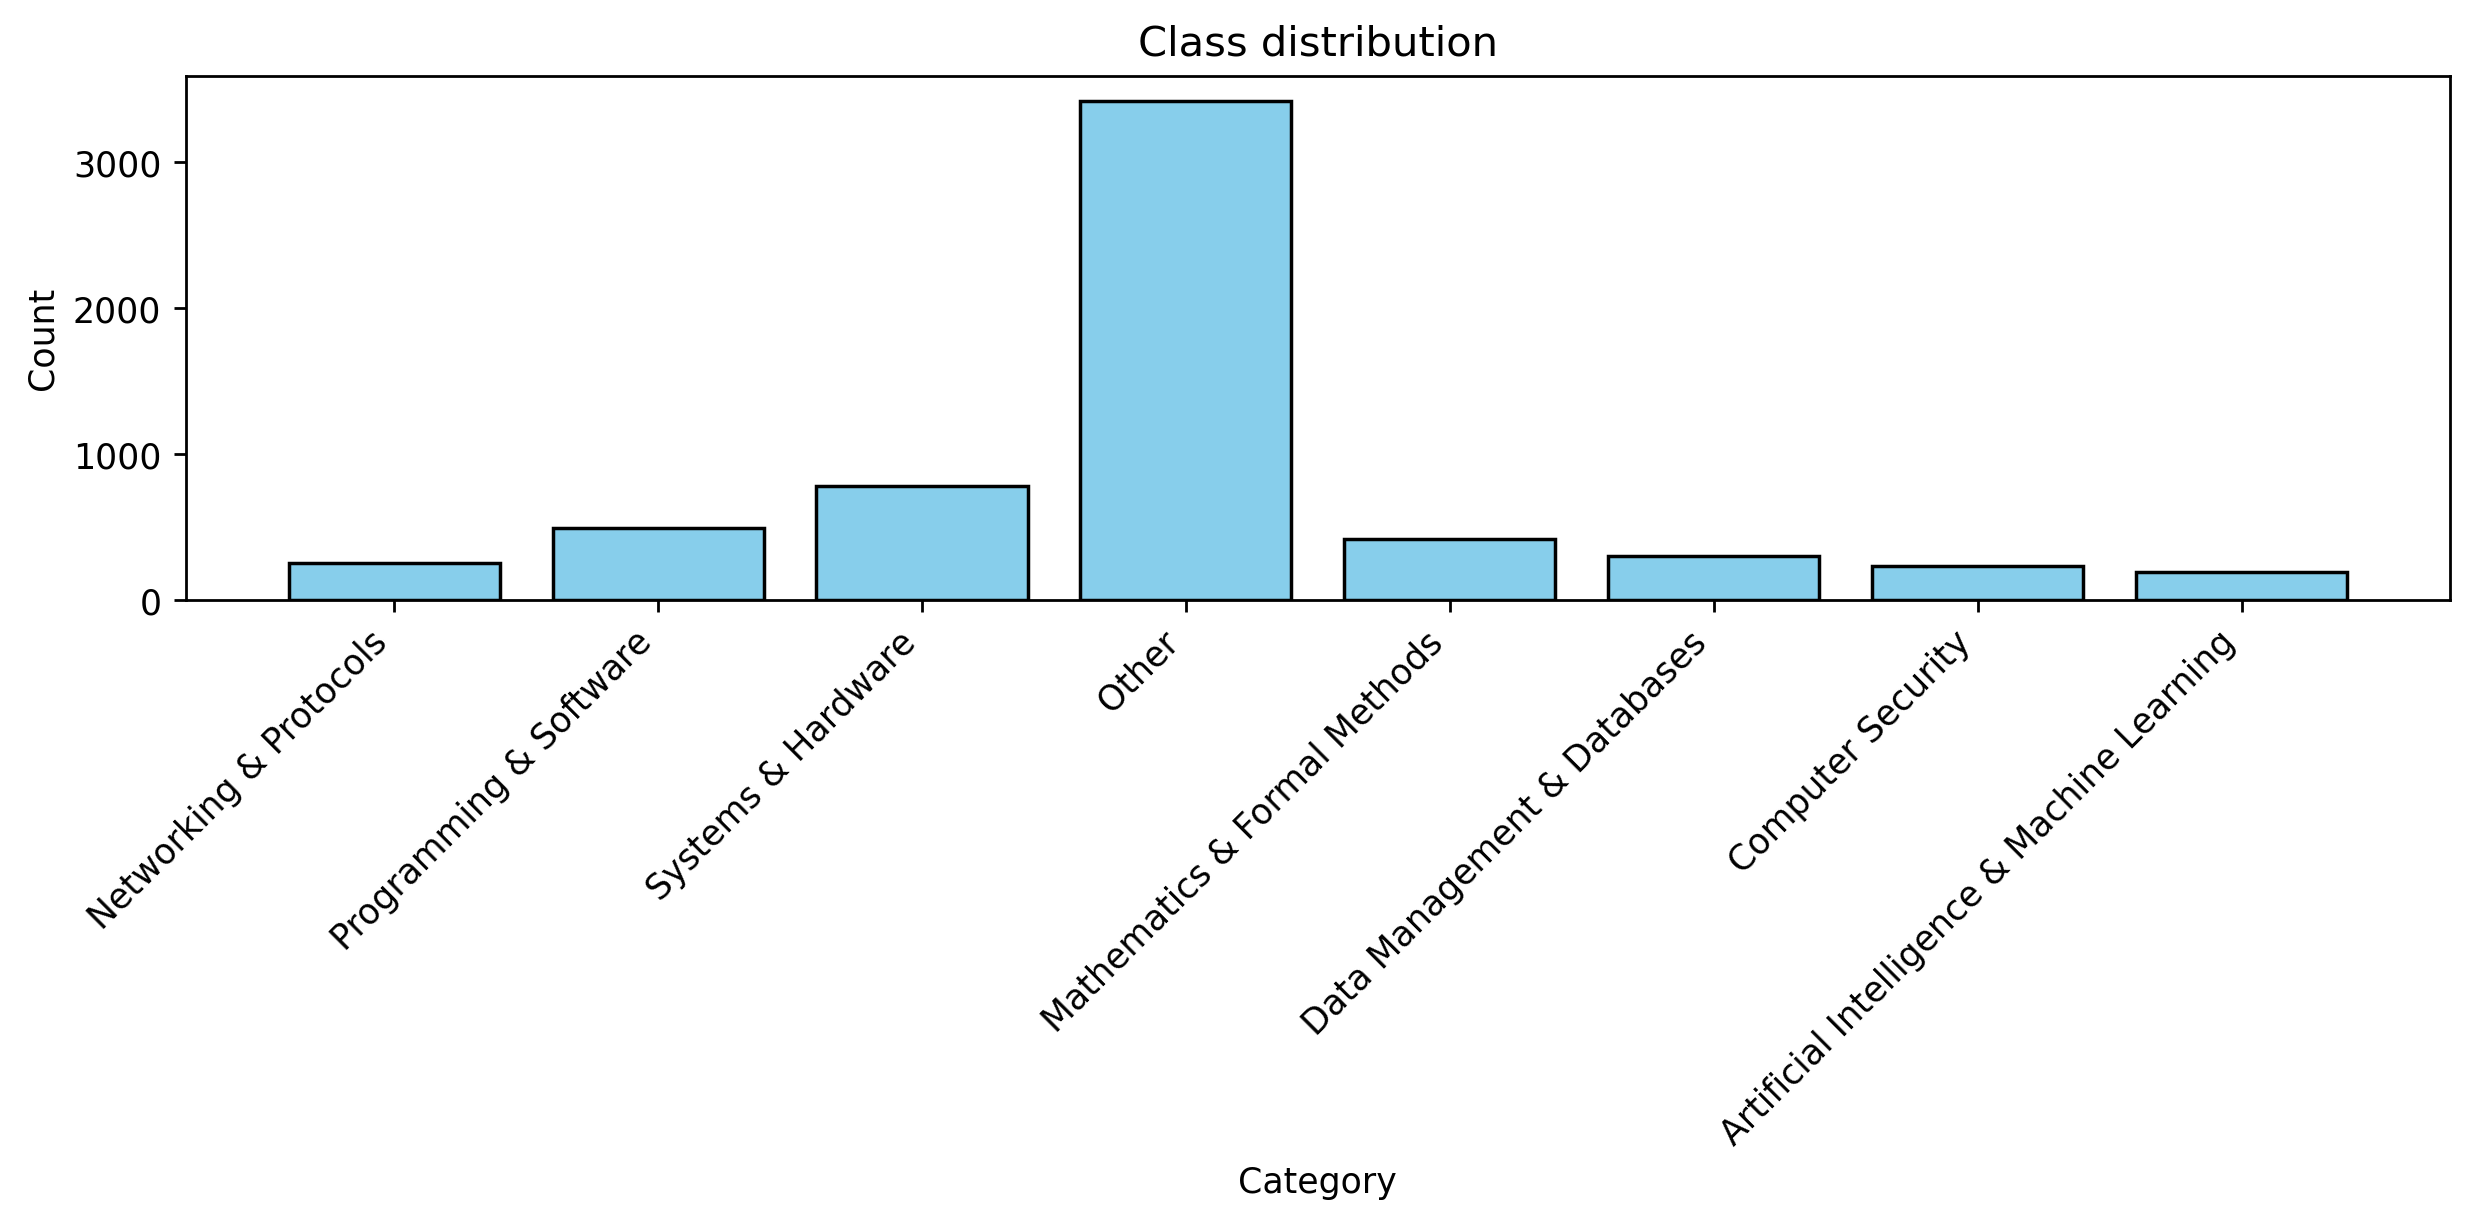

In [67]:
def print_graph_stats(data):
    print("=" * 30)
    print(f"Graph Statistics:")
    print(f"Number of nodes: {data.num_nodes}")

    real_num_edges = data.num_edges / 2
    avg_degree = data.num_edges / data.num_nodes
    print(f"Number of edges (undirected): {int(real_num_edges)}")
    print(f"PyG internal edges (total message paths): {data.num_edges}")
    print(f"Average node degree: {avg_degree:.2f}")

    # Min/Max Degree
    d = degree(data.edge_index[1], num_nodes=data.num_nodes)
    print(f"Min degree: {d.min().item()}")
    print(f"Max degree: {d.max().item()}")

    print(f"Median degree: {d.median().item()}")
    print(f"Number of classes: {len(torch.unique(data.y))}")
    print(f"Has isolated nodes: {data.has_isolated_nodes()}")
    print(f"Has self-loops: {data.has_self_loops()}")
    print(f"Is undirected: {data.is_undirected()}")
    print("=" * 30)


print_graph_stats(data)


idx_to_cat = {i: cat for cat, i in cat_to_idx.items()}
unique, counts = torch.unique(data.y, return_counts=True)
class_names = [idx_to_cat[i.item()] for i in unique]

plt.figure(figsize=(10, 5), dpi=250)
plt.bar(unique.numpy(), counts.numpy(), color="skyblue", edgecolor="black")

plt.title("Class distribution")
plt.xlabel("Category")
plt.ylabel("Count")

plt.xticks(ticks=unique.numpy(), labels=class_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()

Converting to NetworkX (6093 nodes)...
Calculating layout...
Drawing...


/opt/miniconda3/envs/ml/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


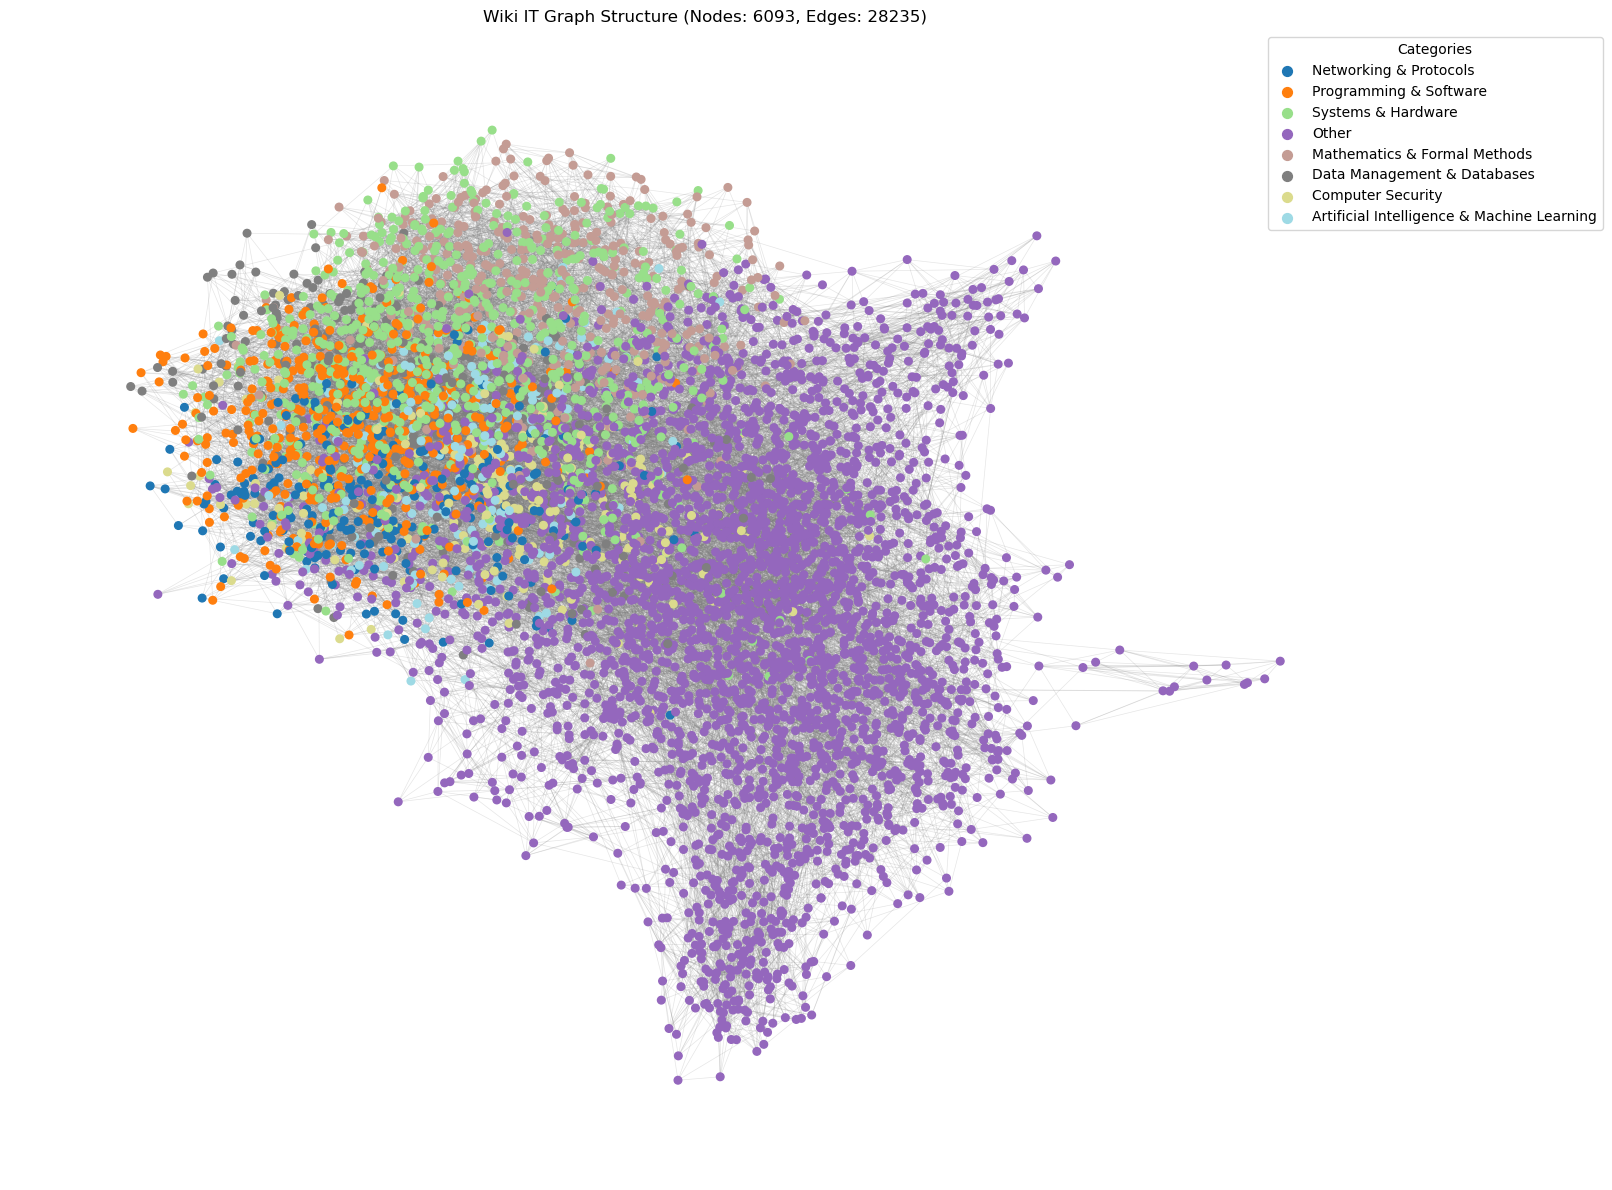

In [84]:
def visualize_static(data, title="Wiki IT Graph Structure"):
    print(f"Converting to NetworkX ({data.num_nodes} nodes)...")
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(data.edge_index.t().tolist())

    node_labels = data.y.numpy()
    unique_classes = np.unique(node_labels)

    cmap = plt.get_cmap("tab20")

    node_colors = []
    for label in node_labels:
        node_colors.append(cmap(label / max(len(unique_classes) - 1, 1)))

    # Calculate graph layout
    print("Calculating layout...")
    pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50)

    print("Drawing...")
    plt.figure(figsize=(16, 12))

    # Edges
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.2,
        edge_color="gray",
        width=0.5,
    )

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, cmap=cmap)

    # Add legend
    for cls_id in unique_classes:
        plt.scatter(
            [],
            [],
            c=[cmap(cls_id / max(len(unique_classes) - 1, 1))],
            label=idx_to_cat[cls_id],
            s=50,
        )

    plt.legend(loc="upper right", title="Categories", bbox_to_anchor=(1.15, 1))
    plt.title(
        f"{title} (Nodes: {data.num_nodes}, Edges: {data.num_edges // 2 if data.is_undirected() else data.num_edges})"
    )
    plt.axis("off")  # remove x,y axis

    plt.tight_layout()
    plt.savefig("wiki_graph_full.png", dpi=250)
    plt.show()


visualize_static(data)